# Comparing Bandit Agents

The notebook (`compare.ipynb`) compares the performance of different bandit agents. The `compare.py` script is for command-line execution. They are automatically paired using `jupytext -s`. 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
from typing import List
import multiprocessing

cores =  multiprocessing.cpu_count() - 1

from bart_playground.bandit.sim_util import *
from compare_agents import (
    AgentSpec, compare_agents_across_scenarios, print_summary_results, plot_comparison_results,
    _ca_logger
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

In [2]:
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
from bart_playground.bart import DefaultBART, LogisticBART
# from bart_playground.bandit.neural_ts_agent import NeuralTSDiagAgent

### Initialization

In [3]:
# Initialize numba

bart_ini = DefaultBART(ndpost=1, nskip=1, n_trees=25)
logistic_bart_ini = LogisticBART(ndpost=1, nskip=1, n_trees=25)

# Simple dataset
X_ini = np.random.uniform(-1, 1, size=(100, 1))
y_ini = np.sin(2 * np.pi * X_ini) + np.random.normal(0, 0.1, size=X_ini.shape)

bart_ini.fit(X_ini, y_ini)

Iterations: 100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


### Simulation Parameters

In [4]:
# default scenario
default_arg = 'Shuttle'
# include more agent variations
extensive = True

n_simulations = 2  # Number of simulations per scenario
max_draws = 200      # Number of draws per simulation

profile = False # Profile the simulation (if True, will use a profiler)

### Scenarios and Agents

#### Scenarios

In [5]:
# Create test scenarios
scenario_factories = {
    "Linear": lambda: LinearScenario(P=10, K=5, d=2, sigma2=1.0),
    "GLM": lambda: GLMScenario(P=5, K=5, sigma2=1.0),
    "Friedman": lambda: FriedmanScenario(P=10, K=2, sigma2=1.0),
    "Friedman2": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman2'),
    "Friedman3": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman3'),
    "LinFriedman": lambda: LinearFriedmanScenario(P=10, K=2, sigma2=1.0),
    "Sparse": lambda: FriedmanScenario(P=20, K=5, sigma2=1.0),
    ## "Isolet": lambda: OpenMLScenario('isolet', version=1),
    "Magic": lambda: OpenMLScenario('MagicTelescope', version=1),
    "Adult": lambda: OpenMLScenario('adult', version=2),
    "Shuttle": lambda: OpenMLScenario('shuttle', version=1),
    ## "Letter": lambda: OpenMLScenario('letter', version=1),
    "Mushroom": lambda: OpenMLScenario('mushroom', version=1),
    "Covertype": lambda: OpenMLScenario('covertype', version=3),
    "MNIST": lambda: OpenMLScenario('mnist_784', version=1),
}

# Parse command-line arguments
args = sys.argv[1:]
cli = True

# Determine which scenarios to run; default if none or invalid
if len(args) == 0 or not any(arg in scenario_factories for arg in args):
    print(f"No valid scenarios specified, using {default_arg}.")
    args = [default_arg]
    cli = False

selected_keys = [k for k in scenario_factories if k in args]
scenarios = {key: scenario_factories[key]() for key in selected_keys}

rep_dataset = selected_keys[0]
# log_encoding = 'native' if rep_dataset in ['Adult', 'Magic', 'Mushroom'] else 'multi' 

# import torch
# torch.manual_seed(0)
# torch.cuda.manual_seed_all(42)

No valid scenarios specified, using Shuttle.


#### Agents

In [6]:
all_agent_specs: List[AgentSpec] = [
    ("Random",      SillyAgent,      {'random_state':0}),
    ("BARTs",       DefaultBARTAgent,       {}),
    ("BARTm",       DefaultBARTAgent,       {}),
    ("BARTo",       DefaultBARTAgent,       {}),
    ("LogisticBARTm", LogisticBARTAgent, {}),
    ("MCBARTs",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
    ("MCBARTm",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
    ("LogisticMCBARTm", MultiChainBARTAgent, { 'bart_class': LogisticBART }),
    ("LinearTS",   LinearTSAgent,   {'v':1}),
    ("LinearTSme",  LinearTSAgent2,  {}),
    # ("RoME",             RoMEAgent,              {'featurize':_featurize, 't_max':n_draws, 'pool_users':False}),
    # ("StandardTS",       StandardTSAgent,        {'featurize':_featurize}),
    # ("ActionCenteredTS", ActionCenteredTSAgent,  {'featurize':_featurize}),
    # ("IntelligentPooling", IntelligentPoolingAgent, {'featurize':_featurize, 't_max':n_draws}),
    # ("BCF",        BCFAgent,        {'nskip':100, 'ndpost':100, 'nadd':3, 'nbatch':1, 'random_state':0}),
    # ("Ensemble",   EnsembleAgent,   {
    #     'bcf_kwargs':       dict(nskip=100, ndpost=10, nadd=2, random_state=0),
    #     'linear_ts_kwargs': dict(v=1)
    # }),
    # ("BCF_PSOff",  BCFAgentPSOff,   {'nskip':100, 'ndpost':10, 'nadd':2, 'nbatch':1, 'random_state':0}),
]

more_agent_specs = []

# generate more agent specifications for parameter variations
for agent_name, agent_class, agent_kwargs in all_agent_specs:
    agent_kwargs['random_state'] = 0
    if 'BART' in agent_name:
        agent_kwargs['nskip'] = 30
        agent_kwargs['ndpost'] = 30
        agent_kwargs['n_trees'] = 50 # default number of trees
        agent_kwargs['nadd'] = 2 # default number of additional iterations
        
        if 'BARTm' in agent_name:
            agent_kwargs['encoding'] = 'multi'
        elif 'BARTo' in agent_name:
            agent_kwargs['encoding'] = 'one-hot'
        elif 'BARTs' in agent_name:
            agent_kwargs['encoding'] = 'separate'
        
        if not 'MCBART' in agent_name:
            agent_kwargs_new = agent_kwargs.copy()
            agent_kwargs_new['n_trees'] = 25
            more_agent_specs.append((f"{agent_name}_tree0.5x", agent_class, agent_kwargs_new.copy()))
            agent_kwargs_new['n_trees'] = 100
            more_agent_specs.append((f"{agent_name}_tree2x", agent_class, agent_kwargs_new.copy()))
            agent_kwargs_new = agent_kwargs.copy()
            agent_kwargs_new['nadd'] = 1
            more_agent_specs.append((f"{agent_name}_iter0.5x", agent_class, agent_kwargs_new.copy()))
            agent_kwargs_new['nadd'] = 4
            more_agent_specs.append((f"{agent_name}_iter2x", agent_class, agent_kwargs_new.copy()))
        else:
            agent_kwargs['nadd'] = 1 # MultiChainBART only needs to use one additional iteration
            agent_kwargs['n_ensembles'] = 4 # default number of ensembles          

In [7]:
if extensive:
    all_agent_specs.extend(more_agent_specs)
else:
    # If not extensive, we only keep some of the agents
    all_agent_specs = [
        agent for agent in all_agent_specs if "MCBART" not in agent[0]
    ]

all_agent_specs = sorted(all_agent_specs, key=lambda x: x[0])

# Filter agents to include only those we want to test
agent_specs = all_agent_specs

### Simulation

In [8]:
if cli:
    results_dir = "./results/compare_cli" # call from CLI
else:
    results_dir = "./results/compare_test_nb" # call from notebook
os.makedirs(results_dir, exist_ok=True)

def call_func():
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        agent_specs=agent_specs,
        sim_indices=list(range(n_simulations)),
        max_draws=max_draws,
        parallel=False,
        save_dir=results_dir,
        log_to_file=True
    )

In [9]:
if profile and not cli:
    %prun -s cumtime -D profile_clog.prof -q call_func()
    !gprof2dot -f pstats profile_clog.prof -o profile_clog.dot
    !dot -Tpng profile_clog.dot -o profile_clog.png
    pass  # For notebook, we run the function and generate a profile
else:
    results = call_func()

INFO bandit_simulator — Logging detailed information to ./results/compare_test_nb/logs.
INFO bandit_simulator — Evaluating Shuttle scenario...
INFO bandit_simulator — Sequentially running simulation.
INFO bandit_simulator — Progress: 0/2. Current sim index: 0. 
2025-06-28 19:53:31,587	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Created 4 BARTActor(s) using BART class: LogisticBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART


Simulating:   0%|          | 0/200 [00:00<?, ?it/s]

Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)...(raylet) WARNING: 36 PYTHON worker processes have been started on node: cec36b60dfe7b7562b690a629f2d38197bf89c81324ce374495a4faf with address: 172.31.3.118. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
 Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initi

Simulating:   2%|▏         | 4/200 [00:31<25:45,  7.89s/it]

 Done.


Simulating: 100%|██████████| 200/200 [02:01<00:00,  1.65it/s]
INFO bandit_simulator — Saved results for simulation 0 of Shuttle in ./results/compare_test_nb/Shuttle_sim0_0628_1955.json.
INFO bandit_simulator — Progress: 1/2. Current sim index: 1. 


Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Created 4 BARTActor(s) using BART class: LogisticBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART
Created 4 BARTActor(s) using BART class: DefaultBART


Simulating:   0%|          | 0/200 [00:00<?, ?it/s]

Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 

Simulating:   2%|▏         | 4/200 [00:32<26:40,  8.17s/it]

 Done.


Simulating: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]
INFO bandit_simulator — Saved results for simulation 1 of Shuttle in ./results/compare_test_nb/Shuttle_sim1_0628_1957.json.


Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.
Ray Actors have been cleaned up.


### Summary Results

In [10]:
print_summary_results(results)


=== Shuttle Scenario ===

Final cumulative regrets (mean ± std):
  BARTm: 59.50 (±0.50)
  BARTm_iter0.5x: 79.00 (±18.00)
  BARTm_iter2x: 60.50 (±3.50)
  BARTm_tree0.5x: 59.50 (±2.50)
  BARTm_tree2x: 70.50 (±9.50)
  BARTo: 77.50 (±23.50)
  BARTo_iter0.5x: 81.50 (±6.50)
  BARTo_iter2x: 49.50 (±3.50)
  BARTo_tree0.5x: 51.00 (±5.00)
  BARTo_tree2x: 59.00 (±3.00)
  BARTs: 168.00 (±5.00)
  BARTs_iter0.5x: 168.00 (±5.00)
  BARTs_iter2x: 168.00 (±5.00)
  BARTs_tree0.5x: 168.00 (±5.00)
  BARTs_tree2x: 168.00 (±5.00)
  LinearTS: 98.00 (±6.00)
  LinearTSme: 88.50 (±2.50)
  LogisticBARTm: 67.50 (±11.50)
  LogisticBARTm_iter0.5x: 57.00 (±0.00)
  LogisticBARTm_iter2x: 62.50 (±2.50)
  LogisticBARTm_tree0.5x: 57.50 (±1.50)
  LogisticBARTm_tree2x: 60.50 (±0.50)
  LogisticMCBARTm: 56.00 (±3.00)
  MCBARTm: 70.00 (±12.00)
  MCBARTs: 168.00 (±5.00)
  Random: 168.00 (±5.00)

Average computation times (seconds):
  BARTm: 5.2047 (±0.9301)
  BARTm_iter0.5x: 2.6563 (±0.0210)
  BARTm_iter2x: 6.5541 (±0.0135)
  

### Visualize Results

Visualize the cumulative regret for each agent across scenarios.

In [11]:
import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump(results, open(result_filename, "wb"))
_ca_logger.info(f"Results saved to {result_filename}")

INFO bandit_simulator — Results saved to ./results/compare_test_nb/result_Shuttle.pkl


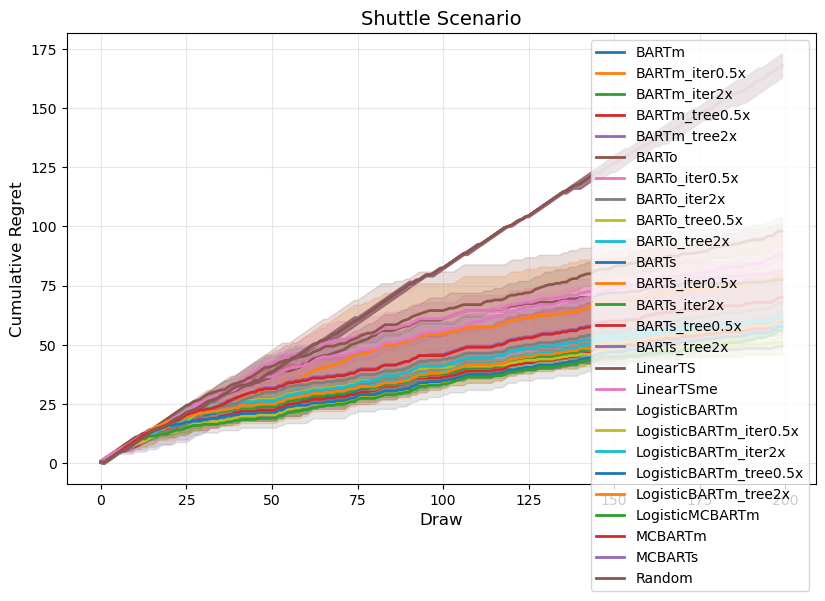

INFO bandit_simulator — Plot saved to ./results/compare_test_nb/agent_comparison_results_Shuttle.png


In [12]:
results = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    save_loc=f"{results_dir}/agent_comparison_results_{appendix_name}.png"
)
_ca_logger.info(f"Plot saved to {results_dir}/agent_comparison_results_{appendix_name}.png")